# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

# Not corr
ind_obs = np.array([[1, 2], [1, 2]])
print(ind_obs)
print(chisquare(ind_obs, axis=None))

# correlated observations
dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# we will not be doing this test or the kruskal today 
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000) # grabbing 1k diff values
# and doing a test to see if it is a normal distrib.
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=57.458706622949144, pvalue=3.3342671078394207e-13)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [4]:
# How to make a certain DF
# chi2 only work with cat variables
gender = ['male', 'male', 'male', 'female', 'female', 'female']
eat_outside = ['outside', 'inside', 'inside', 'inside', 'outside', 'outside']

import pandas as pd
df = pd.DataFrame({"gender": gender, "preference": eat_outside})
df.head(6)

,gender,preference
0,male,outside
1,male,inside
2,male,inside
3,female,inside
4,female,outside
5,female,outside


In [5]:
# crosstab or contingency table
# this has such a small sample size, it is clearly antidote
# do not pass chi2 a DF, pass it a crosstab

table = pd.crosstab(df.gender, df.preference)
table

preference,inside,outside
gender,,
female,1,2
male,2,1


In [6]:
# another way to do a crosstab, but adding in the total observations in the whole DS
# margins are very inmportant doing chi2 tests, because you will need totals

pd.crosstab(df.gender, df.preference, margins=True)

preference,inside,outside,All
gender,,,
female,1,2,3
male,2,1,3
All,3,3,6


In [7]:
df = df.replace("male", 0)
df = df.replace("female", 1)
df = df.replace("outside", 0)
df = df.replace("inside", 1)

df.head(6)

,gender,preference
0,0,0
1,0,1
2,0,1
3,1,1
4,1,0
5,1,0


insert chi2 statistic equation


In [8]:
import numpy as np
# if I were to run a crosstab after this, I would have to go back and remind myself what is what

pd.crosstab(df.gender, df.preference, margins=True)

# go back and figure this out, this is based off of the equation
#total number of obs / total number of cells
expected = np.array([[1.5, 1.5],
                     [1.5, 1.5]])
 
# think about marginal proportions

# marginal proportion of the first row:
# basically taking each of our rows and dividing it by the total
# obs/total = (3 males) / (6 humans)

pd.crosstab(df.gender, df.preference, margins=True, normalize='all')

# observed is a table of the marginal proportions of a subgroup

observed = np.array([[.5,.5],
                     [.5,.5]])
deviation = numerator = observed - expected
print(numerator)

deviation_squared = deviation**2
print("deviation squared \n", deviation_squared)


fraction = (deviation_squared / expected) 
print("fraction: \n", fraction)

chi2 = fraction.sum()
print(chi2 /4)


[[-1. -1.]
 [-1. -1.]]
deviation squared 
 [[1. 1.]
 [1. 1.]]
fraction: 
 [[0.66666667 0.66666667]
 [0.66666667 0.66666667]]
0.6666666666666666


**Another way to think about this**

In [9]:
# this is another way to achieve this
expected_values = [[1.5, 1.5], [1.5, 1.5]]
deviation = (((0.5)**2) / 1.5) * 4  # 0.5^2 deviation per cell, scaled and added
print(deviation)

0.6666666666666666


In [10]:
# degrees of freedom should be 1 minus the number of cells
# if there are 4, dof = 3

chi_data = [[1,2],
            [2,1]]

from scipy.stats import chisquare  # One-way chi square test

chisquare(chi_data, axis=None)

Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)

Contingency Stuff


In [11]:
# this is not right, we have to figure this out

from scipy.stats import chi2_contingency

table = [[.5, .5], [.5, .5]]
chi2statistic, pvalue, dof, observed = chi2_contingency(table) 

print("chi2 stat", chi2statistic)
print("p-value", pvalue)
print('degrees of freedom', dof)
print("Contingency Table: \n", observed)

chi2 stat 0.0
p-value 1.0
degrees of freedom 1
Contingency Table: 
 [[0.5 0.5]
 [0.5 0.5]]


In [12]:
def lazy_chisquare(observed, expected):
  chisquare = 0
  for row_obs, row_exp in zip(observed, expected):
    for obs, exp in zip(row_obs, row_exp):
      chisquare += (obs - exp)**2 / exp
  return chisquare

chi_data = [[1, 2], [2, 1]]
expected_values = [[1.5, 1.5], [1.5, 1.5]]
chistat = lazy_chisquare(chi_data, expected_values)
chistat

0.6666666666666666

## Confidence Intervals

In [13]:
#confidence_interval = [lower_bound, upper_bound]

coin_flips = np.random.binomial(n=1, p=.5, size=100)
print(coin_flips)

[1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0
 0 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1]


In [14]:
# review from yesterdat ttest
import scipy.stats as stats
stats.ttest_1samp(coin_flips, 0.5)

Ttest_1sampResult(statistic=2.4598645869393088, pvalue=0.015632205558326916)

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2., n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [16]:
help(report_confidence_interval)

Help on function report_confidence_interval in module __main__:

report_confidence_interval(confidence_interval)
    Return a string with a pretty report of a confidence interval.
    
    Arguments:
      confidence_interval - tuple of (mean, lower bound, upper bound)
    
    Returns:
      None, but prints to screen the report



In [17]:
coinflip_interval = confidence_interval(coin_flips)  # Default 95% conf
coinflip_interval

print(.43 - .33127)
print(.43 - .52872)

0.09872999999999998
-0.09871999999999997


## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

### **Generate and Numerically represent a CI**

In [0]:
# Pulling in the data from yesterday
cols = [
  'Class Name',
  'handicapped-infants',
  'water-project-cost-sharing',
  'adoption-of-the-budget-resolution',
  'physician-fee-freeze',
  'el-salvador-aid',
  'religious-groups-in-schools',
  'anti-satellite-test-ban',
  'aid-to-nicaraguan-contras',
  'mx-missile',
  'immigration',
  'synfuels-corporation-cutback',
  'education-spending',
  'superfund-right-to-sue',
  'crime',
  'duty-free-exports',
  'export-administration-act-south-africa'
]

congress = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None, names=cols) 

congress.head()

congress = congress.replace({'?':np.nan , 'n':0, 'y':1})
congress = congress.sort_values(by='Class Name')
dems = congress.head(267)
reps = congress.tail(168)

In [19]:
# Taking a look at what the votes per column is
congress.groupby('Class Name').sum()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
Class Name,,,,,,,,,,,,,,,,
democrat,156.0,120.0,231.0,14.0,55.0,123.0,200.0,218.0,188.0,124.0,129.0,36.0,73.0,90.0,160.0,173.0
republican,31.0,75.0,22.0,163.0,157.0,149.0,39.0,24.0,19.0,92.0,21.0,135.0,136.0,158.0,14.0,96.0


In [0]:
# Setting up funtions to define lower, upper, and mean CIs

def lower_CI(data, confidence=0.95):
  n = len(data)
  m, se = np.mean(data), scipy.stats.sem(data)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return m-h

def upper_CI(data, confidence=0.95):
  n = len(data)
  m, se = np.mean(data), scipy.stats.sem(data)
  h = se * sci
  return m+h

def mean_confidence_interval(data, confidence=0.95):
  n = len(data)
  m, se = np.mean(data), scipy.stats.sem(data)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return m

In [0]:
# Pulled in a new column list, excluding Class Name

columnz =["handicapped-infants",
             "water-project-cost-sharing",
             "adoption-of-the-budget-resolution",
             "physician-fee-freeze",
             "el-salvador-aid",
             "religious-groups-in-schools",
             "anti-satellite-test-ban",
             "aid-to-nicaraguan-contras",
             "mx-missile",
             "immigration",
             "synfuels-corporation-cutback",
             "education-spending",
             "superfund-right-to-sue",
             "crime",
             "duty-free-exports",
             "export-administration-act-south-africa"]

### **Use a Plot to represent the CI**

In [0]:
dem_stats=[]
dem_issues=[]

for col in columnz:    
  dem_issues.append(col)
  dem_stats.append(confidence_interval((dems[col]).dropna()))
  
dem_overview = pd.DataFrame(dem_stats,index = dem_issues,columns=['Mean CI', 'Lower CI','Upper CI'])

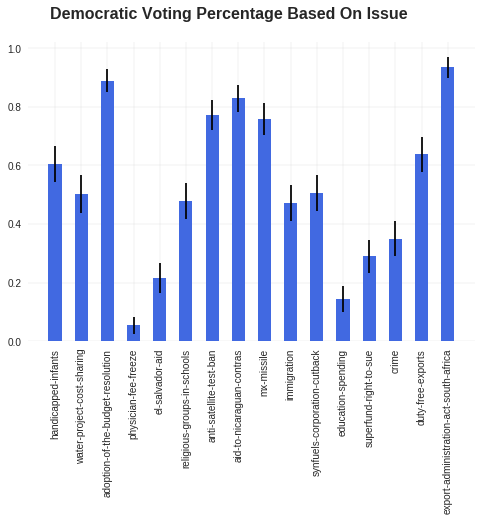

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Setting bar height
bar_height_dem = dem_overview['Mean CI']
 
# Setting height of the Y-Error bars 
yerror_dem = dem_overview['Upper CI'] - dem_overview['Mean CI']
 
# Setting the X positon
x_position = np.arange(len(bar_height_dem))

# Putting it all together
plt.bar(x_position, bar_height_dem, width = 0.5, color = 'royalblue', yerr=yerror_dem, label=None)
 
# General layout
plt.xticks([d for d in range(len(bar_height_dem))], dem_issues, rotation = 90)

# Setting the colors
ax.set_facecolor('#FFFFFF')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)

# Hide Y-label
ax.set_ylabel('')

# Title 
ax.text(s="Democratic Voting Percentage Based On Issue", 
        y=1.1, x=-.2, fontsize=16, fontweight='semibold');

In [0]:
rep_stats=[]
rep_issues=[]

for col in columnz:    
  rep_issues.append(col)
  rep_stats.append(confidence_interval((reps[col]).dropna()))
  
rep_overview = pd.DataFrame(rep_stats,index = rep_issues,columns=['Mean CI', 'Lower CI','Upper CI'])

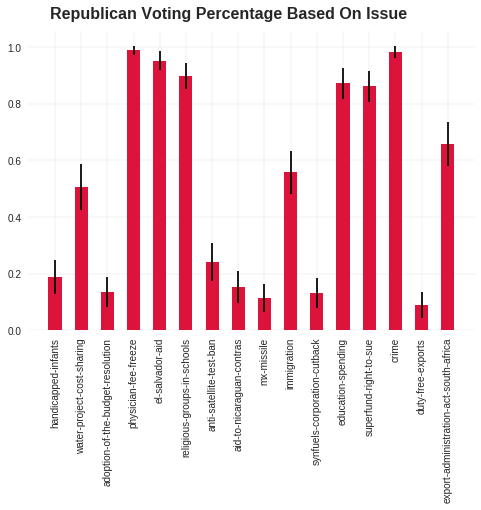

In [27]:
fig, ax = plt.subplots()

# Setting bar height
bar_height_rep = rep_overview['Mean CI']
 
# Setting height of the Y-Error bars 
yerror_rep = rep_overview['Upper CI'] - rep_overview['Mean CI']
 
# Setting the X positon
x_position2 = np.arange(len(bar_height_rep))

# Putting it all together
plt.bar(x_position2, bar_height_rep, width = 0.5, color = 'crimson', yerr=yerror_rep, label=None)
 
# General layout
plt.xticks([r for r in range(len(bar_height_rep))], rep_issues, rotation = 90)

# Setting the colors
ax.set_facecolor('#FFFFFF')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)

# Hide Y-label
ax.set_ylabel('')

# Title 
ax.text(s="Republican Voting Percentage Based On Issue", 
        y=1.1, x=-.2, fontsize=16, fontweight='semibold');

### **Interpret the CI**
** Not sure what this question is asking for, so I repeated the code above and displayed it **

### **Democrat Confidence Intervals**

In [24]:
dem_stats=[]
dem_issues=[]

for col in columnz:    
  dem_issues.append(col)
  dem_stats.append(confidence_interval((dems[col]).dropna()))
  
dem_overview = pd.DataFrame(dem_stats,index = dem_issues,columns=['Mean CI', 'Lower CI','Upper CI'])
dem_overview

,Mean CI,Lower CI,Upper CI
handicapped-infants,0.604651,0.544593,0.664710
water-project-cost-sharing,0.502092,0.438245,0.565939
adoption-of-the-budget-resolution,0.888462,0.849944,0.926980
physician-fee-freeze,0.054054,0.026332,0.081776
el-salvador-aid,0.215686,0.164863,0.266509
religious-groups-in-schools,0.476744,0.415392,0.538097
anti-satellite-test-ban,0.772201,0.720782,0.823620
aid-to-nicaraguan-contras,0.828897,0.783085,0.874710
mx-missile,0.758065,0.704394,0.811735
immigration,0.471483,0.410757,0.532208


###**Republican Confidence Intervals**

In [25]:
rep_stats=[]
rep_issues=[]

for col in columnz:    
  rep_issues.append(col)
  rep_stats.append(confidence_interval((reps[col]).dropna()))
  
rep_overview = pd.DataFrame(rep_stats,index = rep_issues,columns=['Mean CI', 'Lower CI','Upper CI'])
rep_overview

,Mean CI,Lower CI,Upper CI
handicapped-infants,0.187879,0.127652,0.248106
water-project-cost-sharing,0.506757,0.425266,0.588248
adoption-of-the-budget-resolution,0.134146,0.081435,0.186857
physician-fee-freeze,0.987879,0.971007,1.004751
el-salvador-aid,0.951515,0.918398,0.984632
religious-groups-in-schools,0.897590,0.850987,0.944193
anti-satellite-test-ban,0.240741,0.174201,0.307281
aid-to-nicaraguan-contras,0.152866,0.095955,0.209778
mx-missile,0.115152,0.065935,0.164368
immigration,0.557576,0.480996,0.634156


## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)